In [1]:
import re
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import sklearn
from scipy.sparse import vstack
from scipy.special import expit
from scipy.stats import pearsonr, spearmanr
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import accuracy_score, auc, classification_report, roc_curve
from sklearn.model_selection import (
    # LearningCurveDisplay,
    # learning_curve,
    train_test_split,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics._dist_metrics import DistanceMetric
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [5]:
file = "/home/jkuhn/Bachelors-Thesis/input/CountAdded_PIP_global_object_for_cellxgene1.h5ad"
adata_all = sc.read_h5ad(file)
adata_all.var_names_make_unique()
adata_all

AnnData object with n_obs × n_vars = 329762 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

# One hot encoding

In [6]:
encoder_organ = LabelEncoder()
y_encoded = encoder_organ.fit_transform(adata_all.obs["Organ"])  # encode the organ labels

In [7]:
# Replace the existing 'Organ' column with the encoded labels
adata_all.obs["Organ"] = y_encoded

In [8]:
label_table = pd.DataFrame(
    {
        "Encoded_Label": encoder_organ.transform(encoder_organ.classes_),
        "Decoded_Label": encoder_organ.classes_,
    }
)

# Print the table
print(label_table)

    Encoded_Label Decoded_Label
0               0           BLD
1               1           BMA
2               2           CAE
3               3           DUO
4               4           ILE
5               5        JEJEPI
6               6         JEJLP
7               7           LIV
8               8           LLN
9               9           LNG
10             10           MLN
11             11           OME
12             12           SCL
13             13           SKM
14             14           SPL
15             15           TCL
16             16           THY


### Subsetting the dataset: 

In [9]:
celltype = "Monocytes"

In [10]:
adata = adata_all[(adata_all.obs["Majority_voting_CellTypist_high"] == celltype)]

In [11]:
adata

View of AnnData object with n_obs × n_vars = 25611 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [ ]:
# split for each chem and organ for this celltype into train and test
def ttsplit(celltype: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    count = 0

    subset_celltype = adata[(adata.obs["Majority_voting_CellTypist_high"] == celltype)]

    for chem in subset_celltype.obs["Chemistry"].unique():
        subset_chemistry = subset_celltype[
                (subset_celltype.obs["Chemistry"] == chem)
            ]

        for organ in subset_chemistry.obs["Organ"].unique(): 

            subset_organ = subset_chemistry[(subset_chemistry.obs["Organ"] == organ)]
            X = subset_organ.to_df()
            y = subset_organ.obs["Organ"]
            subset_name = f"{celltype}_{organ}_{chem}"
    
            try:
                if count != 0:
                    X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )

                    X_test = pd.concat([X_test, X_test_pre])
                    X_train = pd.concat([X_train, X_train_pre])
                    y_test = pd.concat([y_test, y_test_pre])
                    y_train = pd.concat([y_train, y_train_pre])
                    count = count + 1

                else:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )
                    count = count + 1

            except ValueError as e:

                num_elements = X.shape[0]

                if num_elements == 1:
                    X_train_pre, X_test_pre, y_train_pre, y_test_pre = X, None, y, None

                    X_test = pd.concat([X_test, X_test_pre])
                    X_train = pd.concat([X_train, X_train_pre])
                    y_test = pd.concat([y_test, y_test_pre])
                    y_train = pd.concat([y_train, y_train_pre])

                else:
                    print(f"Subset with name '{subset_name}' caused an error: {e}")

                continue
    return X_train, X_test, y_train, y_test

In [13]:
def save_model(bst: xgb.Booster, modelname: str):
    print("modelname: " + model_name)
    # save model
    bst.save_model(model_name)

In [15]:
def load_model(modelname: str) -> xgb.Booster:
    bst = xgb.Booster()
    bst.load_model(modelname)
    return bst

In [ ]:
def prediction(bst: xgb.Booster) -> pd.DataFrame: # gets model and returns classification report, y_pred_encoded oder adata mit prediction
    y_pred_prob = bst.predict(dtest) # predict
    y_pred_encoded = np.argmax(y_pred_prob, axis =1)

    accuracy = accuracy_score(y_test, y_pred_encoded)
    print(f"Accuracy: {accuracy}")
    
    y_test_decoded = encoder_organ.inverse_transform(
        y_test
    ) 
    y_pred_encoded_series = pd.Series(y_pred_encoded)

    # Map the encoded labels to decoded labels using the label table DataFrame
    y_pred = y_pred_encoded_series.map(
        dict(zip(label_table["Encoded_Label"], label_table["Decoded_Label"]))
    )

    class_report = metrics.classification_report(y_test, y_pred_encoded)

    print("Classification Report for celltype: ", celltype)
    print(class_report)

    with open(report_name, "a") as f:
        print("Classification Report for celltype:", celltype, file=f)
        print(class_report, file=f)

    result_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_encoded})

    actual_counts = result_df["Actual"].value_counts()
    predicted_counts = result_df["Predicted"].value_counts()
    combined_counts = pd.concat([actual_counts, predicted_counts], axis=1)
    combined_counts.columns = ["Actual", "Predicted"]
    combined_counts = combined_counts.fillna(0)  # Fill NaN values with 0

    # Plot the distributions
    combined_counts.plot(kind="bar", figsize=(12, 6))
    plt.title("Distribution of Actual and Predicted Categories for " + celltype)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(["Actual", "Predicted"])
    plt.show()

    return y_pred_encoded

In [18]:
X_train, X_test, y_train, y_test = ttsplit(celltype) 
X = adata.to_df()
y = adata.obs["Organ"]

dtrain = xgb.DMatrix(X_train, label=y_train) 
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
num_classes = len(encoder_organ.classes_)
print("Number of classes:", num_classes)
class_names = encoder_organ.classes_
model_number = "0005"
report_name = f"{model_number}_classification_report.txt"

Number of classes: 17


# Parameter Tuning
Here, the following tutorial was adapted: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [20]:
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.1,
    'subsample': 1.0,
    'colsample_bytree': 0.9,
    "num_class": num_classes,
    # Other parameters
    "objective": "multi:softprob",
    "eval_metric": ['merror','mlogloss'], 
    'device': 'cuda'
}

### Parameters num_boost_round and early_stopping_rounds

In [21]:
# train model with that
evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=10,
    evals_result = evals_result
)
print("Best merror: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[17:20:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/context.cc:44: No visible GPU is found, setting device to CPU.


[0]	train-merror:0.27991	train-mlogloss:2.41292	eval-merror:0.31210	eval-mlogloss:2.42537
[1]	train-merror:0.23498	train-mlogloss:2.15458	eval-merror:0.26573	eval-mlogloss:2.17675
[2]	train-merror:0.20549	train-mlogloss:1.95764	eval-merror:0.23612	eval-mlogloss:1.98730
[3]	train-merror:0.19211	train-mlogloss:1.79970	eval-merror:0.22190	eval-mlogloss:1.83561
[4]	train-merror:0.18024	train-mlogloss:1.66446	eval-merror:0.21099	eval-mlogloss:1.70679
[5]	train-merror:0.17038	train-mlogloss:1.55124	eval-merror:0.20417	eval-mlogloss:1.59998
[6]	train-merror:0.16388	train-mlogloss:1.45342	eval-merror:0.20164	eval-mlogloss:1.50840
[7]	train-merror:0.15573	train-mlogloss:1.36580	eval-merror:0.19501	eval-mlogloss:1.42553
[8]	train-merror:0.14928	train-mlogloss:1.28757	eval-merror:0.19209	eval-mlogloss:1.35179
[9]	train-merror:0.14284	train-mlogloss:1.21651	eval-merror:0.18527	eval-mlogloss:1.28462
[10]	train-merror:0.13937	train-mlogloss:1.15316	eval-merror:0.17943	eval-mlogloss:1.22431
[11]	trai

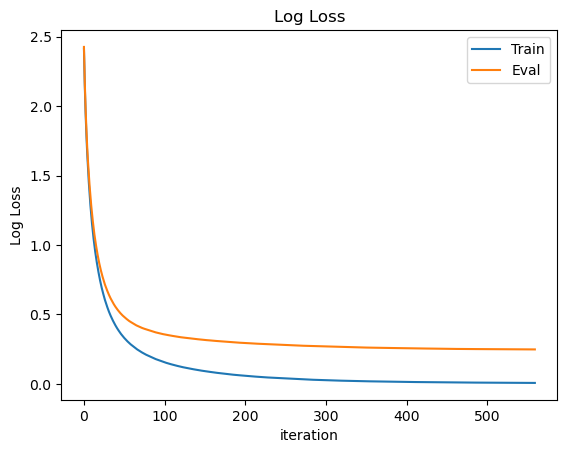

In [22]:
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
ax.plot(x_axis, evals_result['eval']['mlogloss'], label='Eval')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('iteration')
plt.title('Log Loss')
plt.show()

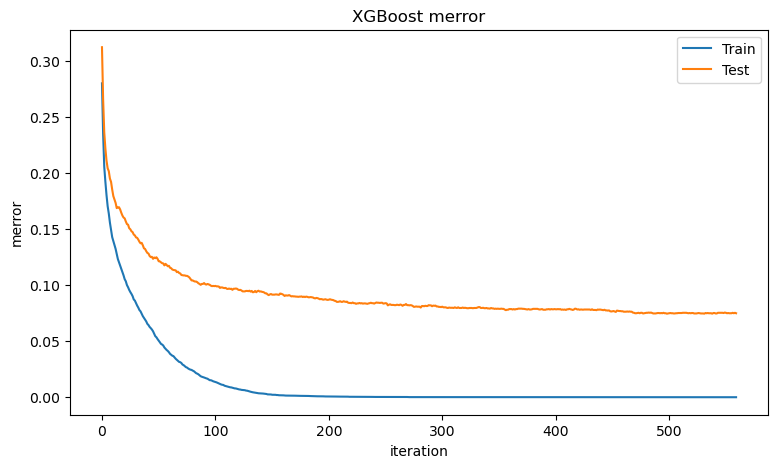

In [23]:
# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, evals_result['train']['merror'], label='Train')
ax.plot(x_axis, evals_result['eval']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.xlabel('iteration')
plt.title('XGBoost merror')
plt.show()

In [24]:
# saving that 
evals_result = {}

num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    evals_result = evals_result
)

[20:34:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/context.cc:44: No visible GPU is found, setting device to CPU.


[0]	Test-merror:0.31210	Test-mlogloss:2.42537
[1]	Test-merror:0.26573	Test-mlogloss:2.17675
[2]	Test-merror:0.23612	Test-mlogloss:1.98730
[3]	Test-merror:0.22190	Test-mlogloss:1.83561
[4]	Test-merror:0.21099	Test-mlogloss:1.70679
[5]	Test-merror:0.20417	Test-mlogloss:1.59998
[6]	Test-merror:0.20164	Test-mlogloss:1.50840
[7]	Test-merror:0.19501	Test-mlogloss:1.42553
[8]	Test-merror:0.19209	Test-mlogloss:1.35179
[9]	Test-merror:0.18527	Test-mlogloss:1.28462
[10]	Test-merror:0.17943	Test-mlogloss:1.22431
[11]	Test-merror:0.17650	Test-mlogloss:1.17024
[12]	Test-merror:0.17339	Test-mlogloss:1.12011
[13]	Test-merror:0.16871	Test-mlogloss:1.07412
[14]	Test-merror:0.16930	Test-mlogloss:1.03277
[15]	Test-merror:0.16949	Test-mlogloss:0.99585
[16]	Test-merror:0.16754	Test-mlogloss:0.96026
[17]	Test-merror:0.16462	Test-mlogloss:0.92728
[18]	Test-merror:0.16209	Test-mlogloss:0.89674
[19]	Test-merror:0.16034	Test-mlogloss:0.86753
[20]	Test-merror:0.15956	Test-mlogloss:0.84165
[21]	Test-merror:0.1568

In [25]:
best_model.save_model("bestMono_softprob.model")

[23:44:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [20]:
# use model later: 
loaded_model = xgb.Booster()
loaded_model.load_model("Models/bestMono_softprob.model")

training done
Accuracy: 0.9244106760179233
Classification Report for celltype:  Monocytes
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1266
           1       0.92      0.93      0.92      1179
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.67      0.20      0.31        20
           6       0.75      0.14      0.23        22
           7       0.90      0.93      0.91       436
           8       0.33      0.02      0.05        41
           9       0.93      0.94      0.94       884
          10       0.00      0.00      0.00         9
          11       1.00      0.40      0.57        10
          12       0.00      0.00      0.00         1
          13       1.00      0.90      0.95        39
          14       0.91      0.94      0.92      1222

    accuracy                           0.92 

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


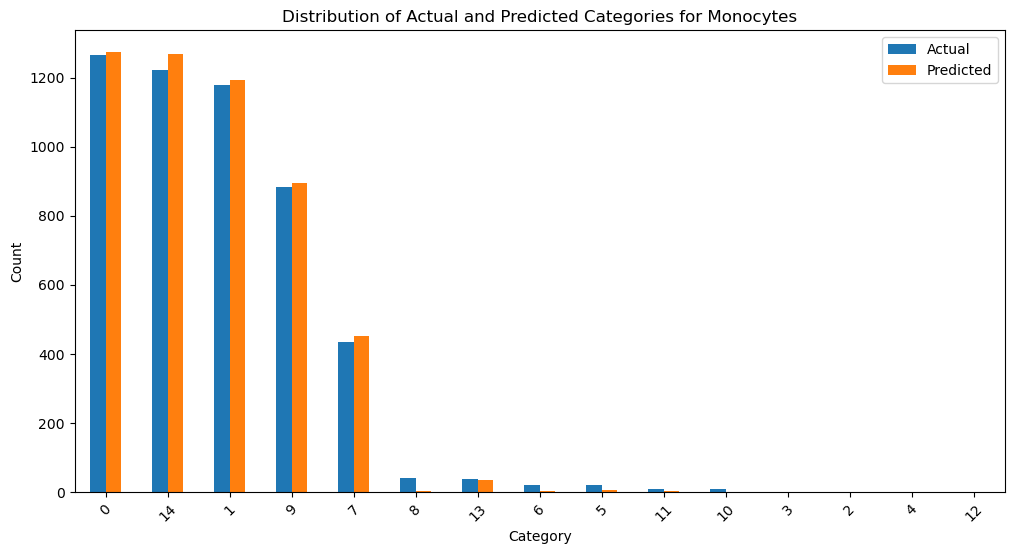

SCORE: 0.9244106760179233


In [21]:
print("training done")
y_pred_encoded = prediction(loaded_model)
y_pred_prob = loaded_model.predict(dtest)
y_pred_encoded = np.argmax(y_pred_prob, axis =1)

accuracy = accuracy_score(y_test, y_pred_encoded)
print ("SCORE:", accuracy)

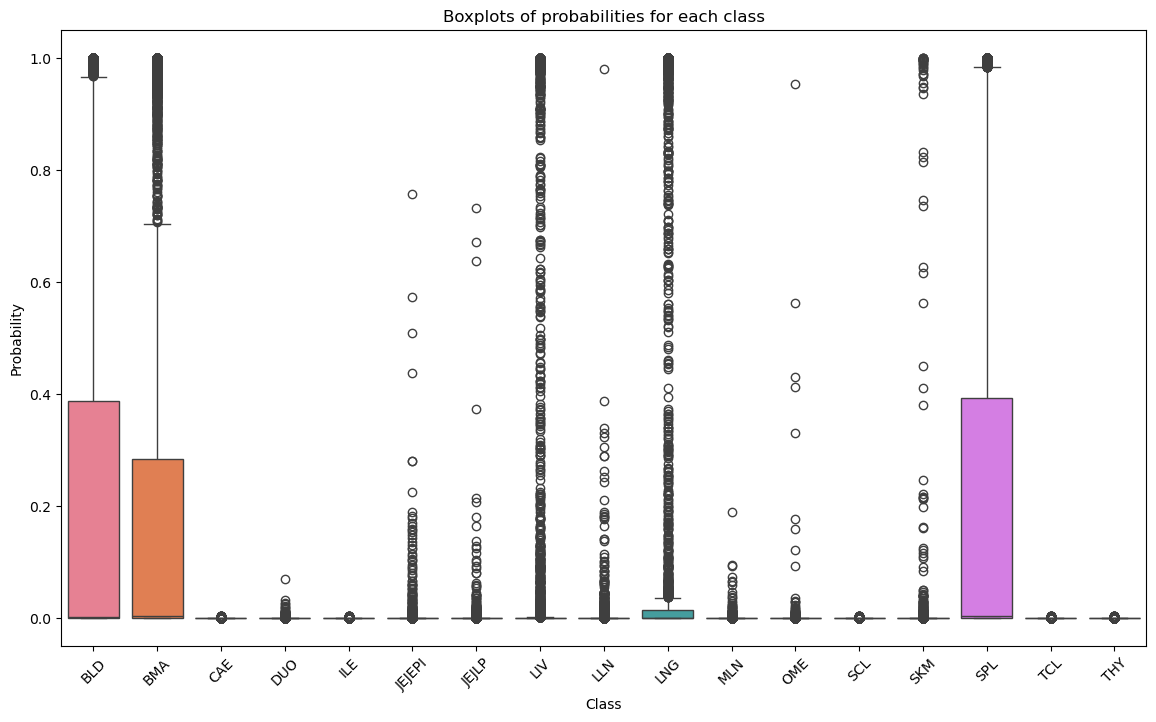

In [29]:
# Convert class indices to class labels
class_labels = label_table['Decoded_Label'].tolist()
df = pd.DataFrame(y_pred_prob, columns=class_labels)

# Boxplot for each class
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots of probabilities for each class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

## Apply on Exercise Dataset

In [30]:
file = "adata_final.h5ad"
print("reading file")
adata2 = sc.read_h5ad(file)
modelname = "Monocytes"

reading file


In [31]:
bst = xgb.Booster()
bst.load_model("bestMono_softprob.model")

In [32]:
subset = adata2[(adata2.obs["celltypist_cell_label_coarse"] == "Monocytes")]
X = subset.to_df()
deval = xgb.DMatrix(X) 

In [33]:
y_pred_prob_ex = loaded_model.predict(deval # predict
predictions = np.argmax(y_pred_prob_ex, axis =1)

In [34]:
label_mapping = {
            0: 'BLD',
            1: 'BMA',
            2: 'CAE',
            3: 'DUO',
            4: 'ILE',
            5: 'JEJEPI',
            6: 'JEJLP',
            7: 'LIV',
            8: 'LLN',
            9: 'LNG',
            10: 'MLN',
            11: 'OME',
            12: 'SCL',
            13: 'SKM',
            14: 'SPL',
            15: 'TCL',
            16: 'THY'
}

In [35]:
# Add predictions to the subset
subset.obs["Predicted_tissue"] = [label_mapping[int(pred)] for pred in predictions]
subset.obs["celltype_model"] = modelname

Trying to modify attribute `.obs` of view, initializing view as actual.


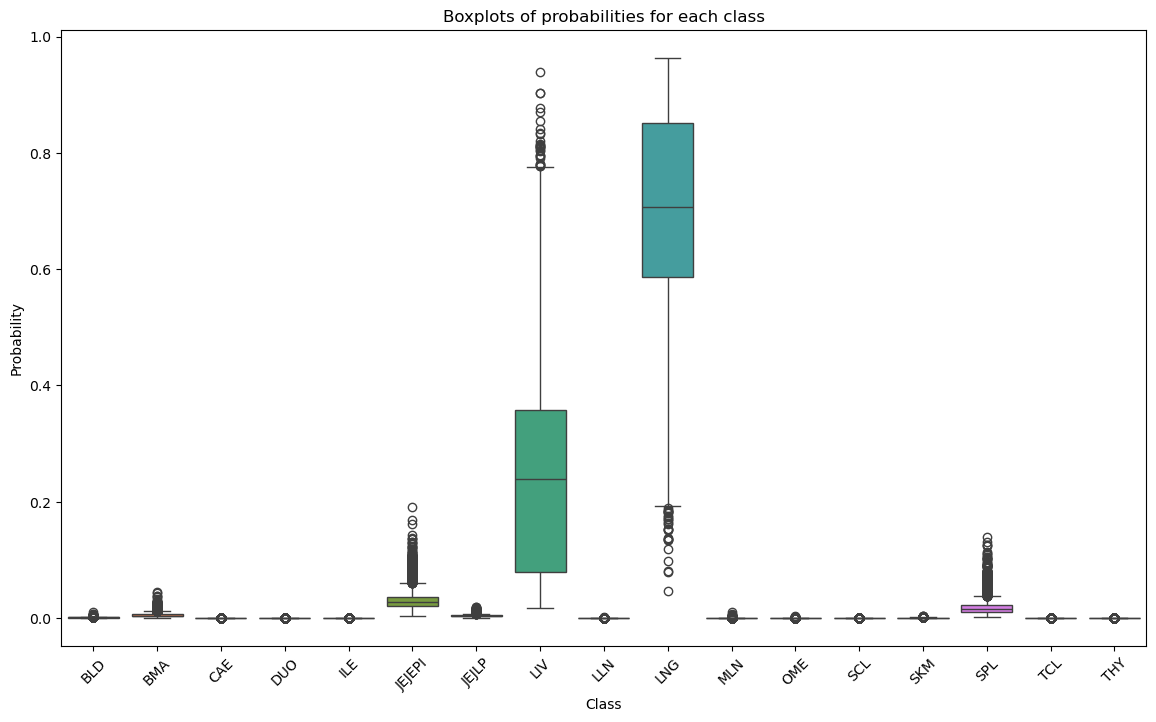

In [36]:
# Convert class indices to class labels 
class_labels = [label_mapping[i] for i in range(y_pred_prob_ex.shape[1])]
df = pd.DataFrame(y_pred_prob_ex, columns=class_labels)

# Boxplot for each class
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots of probabilities for each class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

In [39]:
# Extract 'timepoint' and 'Predicted_tissue' columns
data = {
    'timepoint': subset.obs['timepoint'],
    'Predicted_tissue': subset.obs['Predicted_tissue']
}
df = pd.DataFrame(data)

df = pd.DataFrame(data)

# Group by timepoint and calculate predicted tissue value counts for each timepoint
predicted_tissue_counts_by_timepoint = df.groupby('timepoint')['Predicted_tissue'].value_counts()

# Print the predicted tissue value counts for each timepoint
for timepoint, counts in predicted_tissue_counts_by_timepoint.groupby(level=0):
    print(f"Timepoint {timepoint}:")
    for tissue, count in counts.items():
        print(f"{tissue}\t{count}")
    print()


Timepoint 5b:
('5b', 'LNG')	1979
('5b', 'LIV')	226

Timepoint 5a:
('5a', 'LNG')	2208
('5a', 'LIV')	260

Timepoint 30a:
('30a', 'LNG')	2601
('30a', 'LIV')	230

Timepoint 120a:
('120a', 'LNG')	1842
('120a', 'LIV')	182

